In [1]:
# -*- coding: utf-8 -*-

'''
@Author   :   Corley Tang
@contact  :   cutercorleytd@gmail.com
@Github   :   https://github.com/corleytd
@Time     :   2023-01-27 15:49
@Project  :   Hands-on Deep Learning with PyTorch-building_and_importing_of_basic_neural_network
深度学习基础网络的手动搭建与快速实现
'''

# 导库
import random
import warnings

import numpy as np
import torch
from matplotlib import pyplot as plt
from torch import nn, optim
from torch.nn import functional as F
from torch.utils.data import TensorDataset, DataLoader
from torch.utils.tensorboard import SummaryWriter

from utils.data_gen_split import gen_reg_data, gen_cls_data

# 设置随机种子
seed = 20230127
random.seed(seed)
torch.manual_seed(seed)
# 忽略警告信息
warnings.filterwarnings('ignore')

从前面的过程中可以发现，尽管深度学习也属于机器学习范畴，基本的建模理念和机器学习类似，但实际落地的操作层面、也就是利用PyTorch在进行建模的过程却和经典机器学习有很大的差别，或者说和最大的机器学习库Scikit-Learn中定义的机器学习建模方法有较大的差别：在数据读取过程中，PyTorch需要将数据先封装在一个Dataset的子类中，然后再用DataLoader进行装载，然后才能带入训练，而sklearn则可以直接读取Pandas中存储的面板数据进行建模；在模型调用的过程，PyTorch需要先创建一个Module的子类去定义模型基本结构，然后才能实例化这个模型进行训练，并且训练过程中优化算法也是某个类的实例化结果，在训练过程中需要实用这个类的诸多方法来将梯度清零或者更新神经元之间连接的权重，相比之下sklearn则简单的多，只需要在实例化模型的过程中定义好超参数的取值，然后实用ft方法进行训练即可。之所以PyTorch的整个实现过程看似会更加复杂，是和深度学习建模的特殊性有关。

包括PyTorch在内的深度学习的建模流程实际上都是为了能够更好的满足深度学习建模的一般情况：**针对非结构化数据、在超大规模的数据集上进行模型训练**。PyTorch在读取数据的过程中需要使用Dataset和DataLoader数据进行封装和加载，其实是为了能够实现数据的迭代式存储和映射式存储，也就是通过生成数据的生成器或者保存数据的映射关系，来避免数据的重复存储，如进行小批量数据划分时，PyTorch并未真正意义上的把数据进行切分然后单独存储，而是创建了每个"小批"数据和原数据的映射关系（或者说"小批"数据的索引值)，然后借助这种映射关系，在实际需要使用这些数据的时候在对其进行提取。这么做的原因，当然也是因为当进行海量数据处理时，划分多个数据集进行额外的存储显然是不合适的。同时，在PyTorch的建模过程中，类的频繁使用其实也是为了能够更加灵活地创建不同类型的神经网络模型。
## 1.数据集生成函数的创建与使用
有时候为了实验的需要，需要创建数据生成器，来自主生成一些符合某些条件、具备某些特性的数据集。
### 回归类数据集的创建
回归类模型的数据，特征和标签都是连续型数值。

In [2]:
# 1.手动生成：两个特征、存在偏差，自变量和因变量存在线性关系的数据集——y=2x1-x2+1
num_features = 2  # 特征数
num_samples = 1000  # 样本数

# 系数和截距
w_true = torch.tensor([2., -1])
b_true = torch.tensor(1.)

# 特征和标签
features = torch.randn(num_samples, num_features)
labels_true = torch.mv(features, w_true) + b_true
labels = labels_true + torch.randn_like(labels_true) * 0.01  # 加入扰动项
features.shape, labels.shape

(torch.Size([1000, 2]), torch.Size([1000]))

上面的labels_true和features满足严格意义上的线性方程关系$y = 2x_1-x_2+1$，labels在labels_true的基础上增加了扰动项。这其实也符合一般获取数据的情况：真实客观世界或许存在某个规律，但搜集到的数据往往会因为各种原因存在一定的误差，无法完全描述真实世界的客观规律，这其实也是模型误差的来源之一（另一个误差来源是模型本身捕获规律的能力）。所以，$y=2x_1-x_2+1$相当于从上帝视角创建的数据真实服从的规律，而扰动项则相当于人为创造的获取数据时的误差。**这种按照某种规律生成数据、又人为添加扰动项的创建数据的方法，也是数学领域创建数据的一般方法。**

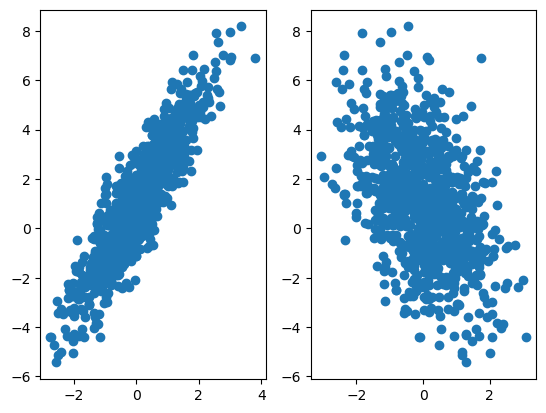

In [3]:
# 可视化特征与标签之间的关系
plt.subplot(121)
plt.scatter(features[:, 0], labels)  # 第1个特征与标签的关系
plt.subplot(122)
plt.scatter(features[:, 1], labels)  # 第2个特征与标签的关系
plt.show()

显然，两个特征和标签都存在一定的线性关系，并且跟特征的系数绝对值有很大关系。如果要增加线性模型的建模难度，可以增加扰动项的数值比例，从而削弱线性关系。可视化验证如下。

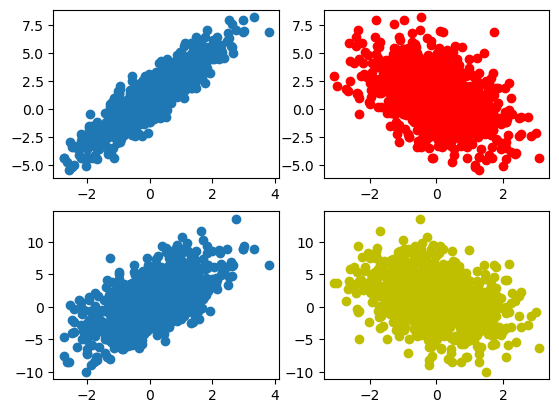

In [4]:
# 可视化线性关系强弱与扰动项大小之间的关系
# 扰动较小
plt.subplot(221)
plt.scatter(features[:, 0], labels)  # 第1个特征与标签的关系
plt.subplot(222)
plt.plot(features[:, 1], labels, 'ro')  # 第2个特征与标签的关系

labels_disturbed = labels_true + torch.randn_like(labels_true) * 2.5  # 标签增大扰动项

# 扰动较大
plt.subplot(223)
plt.scatter(features[:, 0], labels_disturbed)  # 第1个特征与标签的关系
plt.subplot(224)
plt.plot(features[:, 1], labels_disturbed, 'yo')  # 第2个特征与标签的关系
plt.show()

可以看到，3、4幅图因为标签增大了扰动项，因此线性关系减弱、数据分布更加分散。也可以生成非线性关系的数据集。

In [5]:
# 满足y=x^2+1的数据集
b_true = 1
features = torch.randn(num_samples, num_features)
labels_true = torch.square(features) + b_true
labels = labels_true + torch.randn_like(labels_true) * 0.1  # 加入扰动项
features.shape, labels.shape

(torch.Size([1000, 2]), torch.Size([1000, 2]))

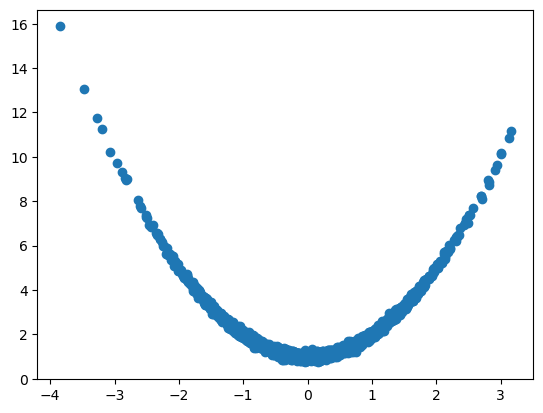

In [6]:
# 可视化
plt.scatter(features, labels)
plt.show()

In [7]:
# 2.创建生成回归类数据的函数
def generate_regression_data(num_samples=1000, w=(1, 1, 0), deg=1, delta=0.01, bias=True):
    '''
    创建回归类数据集
    :param num_samples: 数据集样本量
    :param w: 特征系数向量（包含截距）
    :param deg: 多项式关系的最高次项
    :param delta: 扰动项系数
    :param bias: 是否需要截距
    :return: 生成的特征张量和标签
    '''
    if bias:
        num_features = len(w) - 1  # 特征数
        w_true = torch.tensor(w[:-1], dtype=torch.float)  # 特征系数
        b_true = torch.tensor(w[-1], dtype=torch.float)  # 截距
        features_true = torch.randn(num_samples, num_features)  # 特征张量
        if num_features == 1:  # 若输入特征只有1个，则不能使用矩阵乘法
            labels_true = torch.pow(features_true, deg) * w_true + b_true
        else:
            labels_true = torch.mv(features_true.pow(deg), w_true) + b_true
        features = torch.cat((features_true, torch.ones(features_true.shape[0], 1)), 1)  # 在特征张量的最后添加1列1
        labels = labels_true + torch.randn_like(labels_true) * delta
    else:
        num_features = len(w)
        w_true = torch.tensor(w, dtype=torch.float)
        features = torch.randn(num_samples, num_features)
        if num_features == 1:
            labels_true = torch.pow(features, deg) * w_true
        else:
            labels_true = torch.mv(features.pow(deg), w_true)
        labels = labels_true + torch.randn_like(labels_true) * delta
    return features, labels

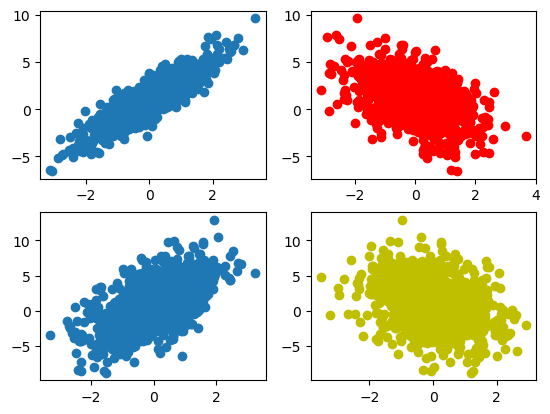

In [8]:
# 进行测试
# 生成扰动较小的数据
f1, l1 = generate_regression_data(w=(2, -1, 1), delta=0.01)
plt.subplot(221)
plt.scatter(f1[:, 0], l1)
plt.subplot(222)
plt.plot(f1[:, 1], l1, 'ro')
# 生成扰动较大的数据
f2, l2 = generate_regression_data(w=(2, -1, 1), delta=2.5)
plt.subplot(223)
plt.scatter(f2[:, 0], l2)
plt.subplot(224)
plt.plot(f2[:, 1], l2, 'yo')
plt.show()

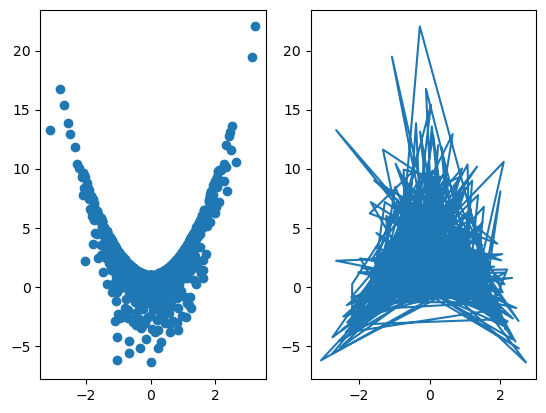

In [9]:
# 二阶关系测试
f3, l3 = generate_regression_data(w=(2, -1, 1), deg=2)
plt.subplot(121)
plt.scatter(f3[:, 0], l3)
plt.subplot(122)
plt.plot(f3[:, 1], l3)
plt.show()

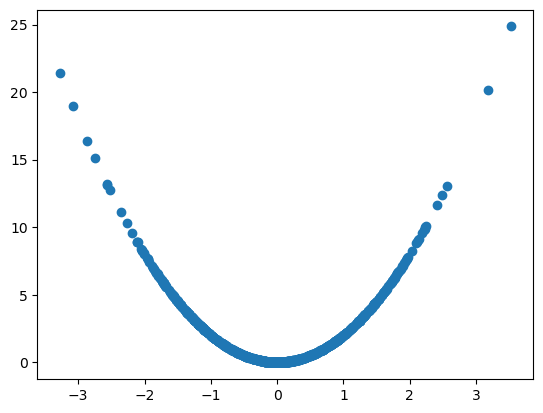

In [10]:
# 只有1个特征
f4, l4 = generate_regression_data(w=(2,), deg=2, bias=False)
plt.scatter(f4, l4)
plt.show()

### 分类数据集的创建
和回归模型的数据不同，分类模型数据的标签是离散值。

In [11]:
# 1.手动创建分类数据集：拥有两个特征的三分类的数据集，每个类别包含500条数据，并且第一个类别服从均值为4、标准差为2的正态分布，第二个类别服从均值为-2、标准差为2的正态分布，第三个类别服从均值为-6、标准差为2的正态分布
num_features = 2  # 特征数
num_samples = 500  # 每个类别的样本数

# 创建各个类别的特征张量
data0 = torch.normal(4, 2, size=(num_samples, num_features))
data1 = torch.normal(-2, 2, size=(num_samples, num_features))
data2 = torch.normal(-6, 2, size=(num_samples, num_features))

# 创建对应的标签
label0 = torch.zeros(num_samples)
label1 = torch.ones(num_samples)
label2 = torch.full((num_samples,), 2)

# 合并获取最终数据
features = torch.cat((data0, data1, data2))
labels = torch.cat((label0, label1, label2)).long().reshape(-1, 1)  # 分类标签应该是整型

features.shape, labels.shape

(torch.Size([1500, 2]), torch.Size([1500, 1]))

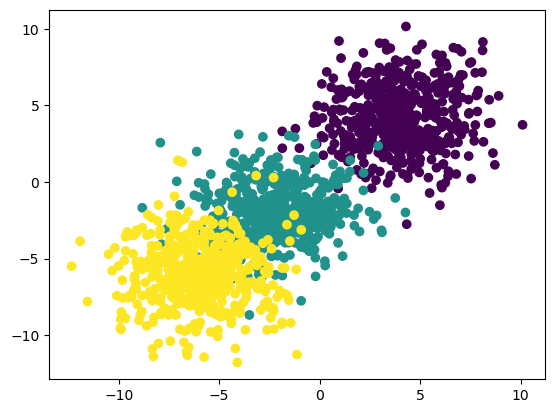

In [12]:
# 可视化展示
plt.scatter(features[:, 0], features[:, 1], c=labels)
plt.show()

可以看到，类别彼此交叉情况较少，分类器在此数据集上会有不错表现。如果要增加分类器的分类难度，可以将各类的均值压缩，并增加方差，从而增加从二维图像上来看彼此交错的情况。

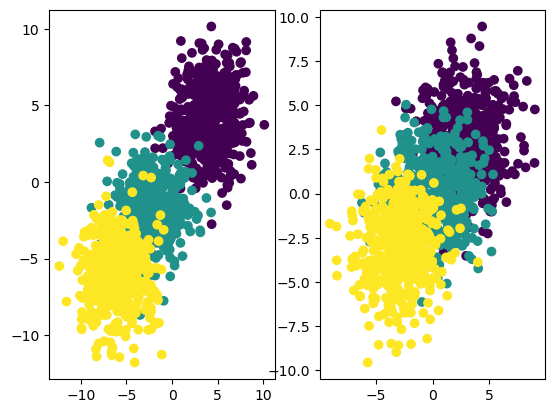

In [13]:
# 探索均值与分类的难度关系
plt.subplot(121)
plt.scatter(features[:, 0], features[:, 1], c=labels)

# 缩小均值的差异
features1 = torch.cat((
    torch.normal(3, 2, size=(num_samples, num_features)),
    torch.normal(0, 2, size=(num_samples, num_features)),
    torch.normal(-3, 2, size=(num_samples, num_features))
))
plt.subplot(122)
plt.scatter(features1[:, 0], features1[:, 1], c=labels)
plt.show()  # 均值分布越近，越不容易分类

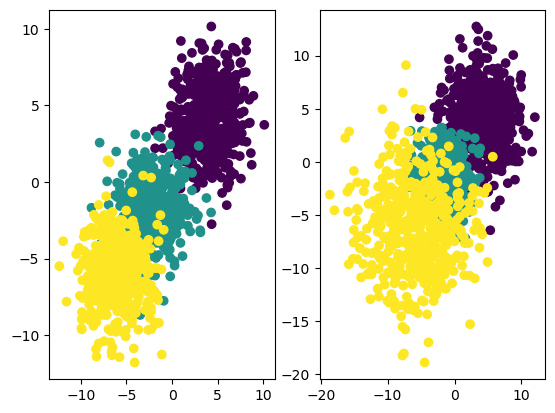

In [14]:
# 探索方差与分类的难度关系
plt.subplot(121)
plt.scatter(features[:, 0], features[:, 1], c=labels)

# 缩小均值的差异
features2 = torch.cat((
    torch.normal(4, 3, size=(num_samples, num_features)),
    torch.normal(-2, 2, size=(num_samples, num_features)),
    torch.normal(-6, 4, size=(num_samples, num_features))
))
plt.subplot(122)
plt.scatter(features2[:, 0], features2[:, 1], c=labels)
plt.show()  # 方差越大，越不容易分类

In [15]:
# 2.创建生成分类数据的函数：需要定义一个变量可以控制数据整体离散程度，也就是后续建模的难以程度，如果每个分类数据集中心点较近、且每个类别的点内部方差较大，则数据集整体离散程度较高，反之离散程度较低
def generate_classification_data(num_features=2, num_samples=500, num_classes=2, dispersions=(4, 2), bias=False):
    '''
    生成分类数据
    :param num_features: 特征数量
    :param num_samples: 每个类别样本数量
    :param num_classes: 类别数
    :param dispersions: 数据分布离散程度，表示(数组均值, 数组标准差)
    :param bias: 建立回归模型时是否需要带入截距
    :return: 特征张量和标签，分别是浮点型和长整型
    '''
    label_ = torch.empty(num_samples, 1)  # 每一类标签的参考
    mean_, std_ = dispersions  # 每一类特征张量的均值和方差
    features, labels = [], []  # 存储每一类别的特征张量和标签
    k = mean_ * (num_classes - 1) / 2  # 每一类特征张量均值的惩罚因子，实现对分布离散程度的控制

    for i in range(num_classes):
        cur_features = torch.normal(i * mean_ - k, std_, size=(num_samples, num_features))  # 每一类特征张量
        cur_labels = torch.full_like(label_, i)  # 每一类标签
        features.append(cur_features)
        labels.append(cur_labels)

    # 合并数据
    features = torch.cat(features).float()
    labels = torch.cat(labels).long()

    # 有截距
    if bias:
        features = torch.cat((features, torch.ones(features.size(0))), -1)

    return features, labels

函数对于分布离散程度的控制：函数内部变量k是一个随着均值增加和分类类别数量增加而增加的数值，且分类数量增加对k值增加影响是通过和1取平均后进行惩罚的结果。而i\*mean_则是一个随着i增加稳步增量的量，两者相减最终能获得一个**整体特征均匀分布在0附近**的特征张量。

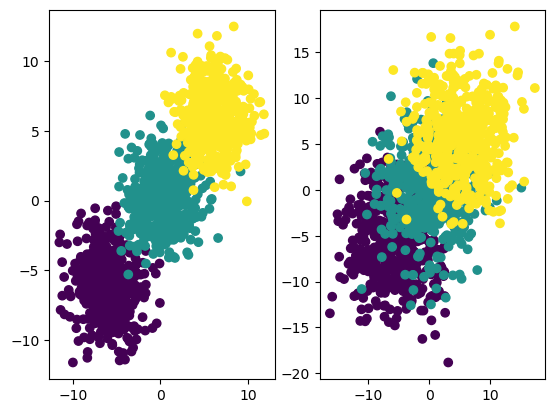

In [16]:
# 进行测试
# 生成分类数据
f5, l5 = generate_classification_data(num_classes=3, dispersions=(6, 2))  # 离散程度较小
f6, l6 = generate_classification_data(num_classes=3, dispersions=(6, 4))  # 离散程度较大

# 可视化
plt.subplot(121)
plt.scatter(f5[:, 0], f5[:, 1], c=l5)
plt.subplot(122)
plt.scatter(f6[:, 0], f6[:, 1], c=l6)
plt.show()  # 右图离散程度更大，边界更不明显，分类难度更大

### 创建小批量切分函数
在深度学习建模过程中，梯度下降是最常用的求解目标函数的优化方法，而针对不同类型、拥有不同函数特性的目标函数，所使用的梯度下降算法也各有不同小批量梯度下降（MBGD）是较为“普适”的优化算法，它既拥有随机梯度下降（SGD）的能够跨越局部最小值点的特性，同时又和批量梯度下降（BGD）一样，拥有相对较快的收敛速度（虽然速度略慢与BGD）。而在小批量梯度下降过程中，需要对函数进行分批量的切分现在定义数据集小批量切分的函数。

In [17]:
# 定义数据分批函数：根据设置的“批数”，将原数据集随机均匀切分，不使用Dataset和DataLoader
def data_split_batches(batch_size, features, labels, shuffle=True):
    '''
    数据切分
    :param batch_size: 分配的大小，即每个小批量包含多少样本
    :param features: 特征张量
    :param labels: 标签
    :param shuffle: 是否随机打乱
    :return: 由切分后的特征和标签组成的列表
    '''
    num_samples = labels.size(0)
    indices = list(range(num_samples))
    if shuffle:  # 随机打乱
        random.shuffle(indices)
    batches = []
    for idx in range(0, num_samples, batch_size):
        slice_indices = torch.tensor(indices[idx:idx + batch_size])
        batches.append((torch.index_select(features, 0, slice_indices), torch.index_select(labels, 0, slice_indices)))

    return batches

In [18]:
# 测试
# 生成二分类数据
features, labels = generate_classification_data(num_classes=3)
# 分批
batches = data_split_batches(16, features, labels)
batches[0]

(tensor([[ 0.4247, -2.3494],
         [-3.6606, -6.5917],
         [-0.8315,  4.2044],
         [-4.6713, -4.5975],
         [-6.6039, -7.3751],
         [ 7.2411,  2.0633],
         [-1.2231, -1.5118],
         [ 1.9689,  0.9882],
         [ 1.4535,  0.2070],
         [-6.8950, -1.4397],
         [-0.5551, -0.9326],
         [-3.0866, -2.7888],
         [ 1.7843,  1.6552],
         [-3.1524,  3.1168],
         [-4.6973, -3.3887],
         [ 2.9147,  2.6736]]),
 tensor([[1],
         [0],
         [1],
         [0],
         [0],
         [2],
         [1],
         [1],
         [1],
         [0],
         [1],
         [0],
         [1],
         [1],
         [0],
         [2]]))

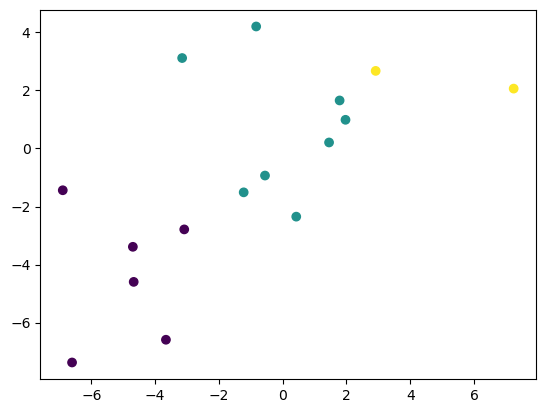

In [19]:
# 可视化第1个batch
batch_features, batch_labels = batches[0]
plt.scatter(batch_features[:, 0], batch_features[:, 1], c=batch_labels)
plt.show()  # 数据已经被随机打乱

上面使用了空列表来存储数据。但是需要注意，在经典机器学习领域，经常使用空的列表来存储经过处理之后的数据，这么做能直观获取数据的真实情况，但在深度学习领域，这么做是不合理的，因为在深度学习领域，数据量往往非常大，甚至数据本身就是分布式存储的，要调取数据进行完整的查看，一方面会耗费大量的存储空间，另一方面也会消耗一定的算力，因此PyTorch的Dataset和DataLoader都是将数据进行迭代存储或者映射存储。
### 自定义函数保存到模块
前面定义的函数是经常会用到的，如果每次都要重新定义显然很不方便，因此可以保存到模块中：
1. 在项目目录下创建一个Python Package（普通文件夹下创建__init__.py即成为包），包名为utils，用于保存各种哦你根据函数
2. 下面创建Python文件用于保存前面定义的函数，例如data_gen_split.py
3. 将函数代码复制到data_gen_split.py即可，并导入所需的库

data_gen_split.py代码示例如下：
```python
# -*- coding: utf-8 -*-

'''
@Author   :   Corley Tang
@contact  :   cutercorleytd@gmail.com
@Github   :   https://github.com/corleytd
@Time     :   2023-01-27 23:35
@Project  :   Hands-on Deep Learning with PyTorch-data_gen_split
数据的生成与切分
'''

import random

import torch


def gen_reg_data(num_samples=1000, w=(1, 1, 0), deg=1, delta=0.01, bias=True):
    '''
    创建回归类数据集
    :param num_samples: 数据集样本量
    :param w: 特征系数向量（包含截距）
    :param deg: 多项式关系的最高次项
    :param delta: 扰动项系数
    :param bias: 是否需要截距
    :return: 生成的特征张量和标签
    '''
    if bias:
        num_features = len(w) - 1  # 特征数
        w_true = torch.tensor(w[:-1], dtype=torch.float)  # 特征系数
        b_true = torch.tensor(w[-1], dtype=torch.float)  # 截距
        features_true = torch.randn(num_samples, num_features)  # 特征张量
        if num_features == 1:  # 若输入特征只有1个，则不能使用矩阵乘法
            labels_true = torch.pow(features_true, deg) * w_true + b_true
        else:
            labels_true = torch.mv(features_true.pow(deg), w_true) + b_true
        features = torch.cat((features_true, torch.ones(features_true.shape[0], 1)), 1)  # 在特征张量的最后添加1列1
        labels = labels_true + torch.randn_like(labels_true) * delta
    else:
        num_features = len(w)
        w_true = torch.tensor(w, dtype=torch.float)
        features = torch.randn(num_samples, num_features)
        if num_features == 1:
            labels_true = torch.pow(features, deg) * w_true
        else:
            labels_true = torch.mv(features.pow(deg), w_true)
        labels = labels_true + torch.randn_like(labels_true) * delta
    return features, labels


def gen_cls_data(num_features=2, num_samples=500, num_classes=2, dispersions=(4, 2), bias=False):
    '''
    生成分类数据
    :param num_features: 特征数量
    :param num_samples: 每个类别样本数量
    :param num_classes: 类别数
    :param dispersions: 数据分布离散程度，表示(数组均值, 数组标准差)
    :param bias: 建立回归模型时是否需要带入截距
    :return: 特征张量和标签，分别是浮点型和长整型
    '''
    label_ = torch.empty(num_samples, 1)  # 每一类标签的参考
    mean_, std_ = dispersions  # 每一类特征张量的均值和方差
    features, labels = [], []  # 存储每一类别的特征张量和标签
    k = mean_ * (num_classes - 1) / 2  # 每一类特征张量均值的惩罚因子，实现对分布离散程度的控制

    for i in range(num_classes):
        cur_features = torch.normal(i * mean_ - k, std_, size=(num_samples, num_features))  # 每一类特征张量
        cur_labels = torch.full_like(label_, i)  # 每一类标签
        features.append(cur_features)
        labels.append(cur_labels)

    # 合并数据
    features = torch.cat(features).float()
    labels = torch.cat(labels).long()

    # 有截距
    if bias:
        features = torch.cat((features, torch.ones(features.size(0))), -1)

    return features, labels


def data_split_batches(batch_size, features, labels, shuffle=True):
    '''
    数据切分
    :param batch_size: 分配的大小，即每个小批量包含多少样本
    :param features: 特征张量
    :param labels: 标签
    :param shuffle: 是否随机打乱
    :return: 由切分后的特征和标签组成的列表
    '''
    num_samples = labels.size(0)
    indices = list(range(num_samples))
    if shuffle:  # 随机打乱
        random.shuffle(indices)
    batches = []
    for idx in range(0, num_samples, batch_size):
        slice_indices = torch.tensor(indices[idx:idx + batch_size])
        batches.append((torch.index_select(features, 0, slice_indices), torch.index_select(labels, 0, slice_indices)))

    return batches

```
调用示意如下：
```python
from utils.data_gen_split import gen_cls_data, data_split_batches

features, labels = gen_cls_data()
batches = data_split_batches(8, features, labels)
```

## 2.可视化工具TensorBoard的安装与使用
在深度学习建模过程中，为了能够快速绘制模型基本结构、观察模型评估指标伴随训练过程的动态变化情况，当然也为了能够观察图像数据，我们可以使用TensorBoard工具来进行PyTorch深度学习模型的可视化展示。Tensorboard原本是TensorFlow的可视化工具，其他深度学习计算框架也可使用TensorBoard工具进行可视化操作。在PyTorch原生的可视化工具不够友好的情况下，更推荐使用TensorBoard来实现PyTorch的建模可视化。TensorBoard采用的是是本地开启服务、本地记录结果、Web读取结果的模式。
### TensorBoard的安装
在命令行中执行以下命令安装TensorBoard：
```shell
pip install tensorboard
```
### Tensorboard与SummaryWriter类的基本使用
在使用Tensorboard进行建模过程可视化展示的过程中，最主要使用的类就是SummaryWriter类，通过该类记录关键运算关系、模型数值指标等，并进行展示，具体做法是将需要记录的关键结果记录下来并保存在本地文件中，然后再在本地或者服务器上开启某项服务读取该文件保存的信息。整个过程会比在本地绘图稍微复杂，但确是真实生产环境中的主流操作。如下图所示：

![tensorboard_process](../assets/tensorboard_process.png)

下面进行简单的使用。

In [20]:
# 实例化SummaryWriter
writer = SummaryWriter()
writer, writer.log_dir

(<torch.utils.tensorboard.writer.SummaryWriter at 0x234464214c0>,
 'runs\\Mar21_11-10-50_DESKTOP-4RHNCJI')

可以看到，实例化时使用的是默认参数，`log_dir`参数值为runs，当文件夹不存在时，SummaryWriter会自动创建。每次实例化一次SummaryWriter，就会在对应文件夹内新生成一个文件夹，用于保存本次实例化的writer写入的数据。单个文件夹内允许存在多个文件，在实际读取过程中会一次性读取文件夹内全部文件。还有一个常用的参数——`comment`，通过comment参数的设置，可以自由设置每个实例化类的过程中文件名称的后缀。

In [21]:
# 记录数据
for i in range(10):
    writer.add_scalar('exp', 1.1 ** i, i)

这里使用了add_scalar方法记录数据，该方法用于记录标量，在实际记录过程中，通过迭代的方式逐个增加。其中：
- 第一个参数代表改组记录的名称（也就是生成图像的名称）
- 第二个参数代表y值
- 第三个参数代表x值

实际上add_scalar方法的核心应用场景是用于记录模型运行过程中随着迭代次数增加一些数值指标的变化情况，如loss值、准确率值等，Tensorboard的应用场景也是深度学习建模过程的可视化展示。完成记录后，即可读取文件查看记录结果。除此以外，其他的还有add_graph、add_image、add_histogram等方法用于记录深度学习建模流程。
得到了记录好的数据后，就可以通过启动服务读取生成的记录文件，命令为：
```shell
tensorboard --logdir="runs"
```
需要在操作目录下执行该目录，即执行writer的一系列add方法所在的目录。命令行中的tensorboard为指令关键词，`--logdir`参数输入日志路径，与SummaryWriter类的logdir参数一致。在默认情况下，系统会自动启动6006端口，可用于Web调用服务。logdir参数也可以是进入日志路径下的某个子文件夹，用于特定可视化某一次生成的数据。如果默认6006端口冲突，也可自行修改服务端口号，只需指定输入参数`--port XXXX`即可。当然，通过Web调用的服务，也可以远程调用，只需要修改配置文件即可。
开启服务后，即可在浏览器中输入[localhost:port](localhost:port)进行访问，例如[http://localhost:6006/](http://localhost:6006/)。访问效果如下：
![tensorboard_scalar_demo](../assets/tensorboard_scalar_demo.png)

在页面中，可以对数据进行简单操作、很方便地查看数据。
## 3.线性回归建模实验
### 深度学习建模流程
在实际深度学习建模过程中，无论是手动实现还是调库实现，我们都需要遵循深度学习建模一般流程，如下：
1. 模型选择：确定神经网络的层数、每一层神经元的个数，以及选择激活函数
2. 确定目标函数：构建一个包含模型参数的函数方程、并且方程取值和建模目标一致，大多数情况都是沿着方程极小值求解
3. 选择优化方法：根据损失函数的函数特性，兼顾实际算力的消耗，选择一项最优化工具，往往也就是某项数学工具
4. 模型训练：利用优化方法，求解损失函数，并得到一组模型参数，对应在神经网络中,就是得到一组连接神经元的边的参数取值
### 线性回归的手动实现

In [22]:
# 1.构造数据：y=2x1-x2+1
features, labels = generate_regression_data(w=(2, -1, 1))
features.shape, labels.shape

(torch.Size([1000, 3]), torch.Size([1000]))

\# 2.模型选择：构建一个只包含一层的神经网络
网络结构如下：
![handson_linear_regression_nn](../assets/handson_linear_regression_nn.png)

In [23]:
def lin_reg(X, w):
    return X @ w

In [24]:
# 3.确定目标函数：确定MSE作为损失函数，即目标函数
def mse(y_hat, y):
    return (y_hat - y).square().sum() / y_hat.size(0)

In [25]:
# 4.定义优化算法：采用小批量梯度下降，参数=参数-学习率*梯度
def sgd(params, lr):
    params.data -= lr * params.grad
    params.grad.zero_()

In [26]:
# 可微张量的原地操作（in-place operation）：
# 正常情况下，可微张量的原地操作会导致系统无法区分叶节点和其他节点
w = torch.tensor(2., requires_grad=True)
w = w * 2
w.backward()
w.grad  # w成为输出节点，非叶子结点grad值为None，没有变量指向原来的叶子结点，计算图如果缺少对叶节点反向传播求导数的相关运算，计算图也就失去了核心价值，因此应尽量避免导致叶节点丢失的相关操作

In [27]:
# 修改叶节点数值：如果出现了一定要修改叶节点值的情况，典型的如梯度下降过程中利用梯度值修改参数值时，可以使用暂停追踪的方法
# （1）利用with torch.no_grad()暂停追踪
w = torch.tensor(2., requires_grad=True)
with torch.no_grad():
    w -= w * 2
w, w.is_leaf

(tensor(-2., requires_grad=True), True)

In [28]:
# （2）利用detach()方法生成新张量
w = torch.tensor(2., requires_grad=True)
w.detach_()
w -= w * 2
w

tensor(-2.)

In [29]:
w.requires_grad = True
w, w.is_leaf

(tensor(-2., requires_grad=True), True)

In [30]:
# （3）.data属性返回可微张量的取值，从在避免在修改的过程中被追踪
w = torch.tensor(2., requires_grad=True)
w, w.data

(tensor(2., requires_grad=True), tensor(2.))

In [31]:
w.data -= w * 2  # 对其数值进行修改
w, w.is_leaf  # 张量仍然是叶节点，不改变张量本身可微性

(tensor(-2., requires_grad=True), True)

In [32]:
# 4.模型训练
# 设置超参数
lr = 0.03
num_epochs = 5
batch_size = 16

# 初始化权重参数
w = torch.zeros(3, requires_grad=True)

# 定义模型与损失函数
model = lin_reg
criterion = mse

# 迭代训练
loss = 0
for epoch in range(num_epochs):
    for X, y in data_split_batches(batch_size, features, labels):
        y_hat = model(X, w)
        loss = criterion(y_hat, y)
        loss.backward()
        sgd(w, lr)
    epoch_loss = criterion(model(features, w), labels)
    print(f'epoch {epoch} loss: {epoch_loss.item():.6f}')

w  # 查看得到的参数值，与真实的线性关系（y=2x1-x2+1）很接近

epoch 0 loss: 0.003400
epoch 1 loss: 0.000101
epoch 2 loss: 0.000099
epoch 3 loss: 0.000099
epoch 4 loss: 0.000099


tensor([ 1.9994, -0.9995,  1.0001], requires_grad=True)

In [33]:
# 用TensorBoard记录损失
loss = 0
w = torch.zeros(3, requires_grad=True)
writer = SummaryWriter()  # 实例化SummaryWriter
for epoch in range(num_epochs):
    for X, y in data_split_batches(batch_size, features, labels):
        y_hat = model(X, w)
        loss = criterion(y_hat, y)
        loss.backward()
        sgd(w, lr)
    epoch_loss = criterion(model(features, w), labels)
    writer.add_scalar('loss_lin_reg_by_hand', epoch_loss, epoch)

### 线性回归的快速实现
除了自己实现，也可以通过调用PyTorch中的函数和类来完成建模。

In [34]:
# 1.定义超参数
batch_size = 16
lr = 0.03
num_epochs = 5

In [35]:
# 2.构造数据
features, labels = gen_reg_data(w=(2, -1, 1), bias=False)
features = features[:, :-1]
labels += 1
data = TensorDataset(features, labels)
loader = DataLoader(data, batch_size=batch_size, shuffle=True)
loader

In [36]:
# 3.定义模型
class LR(nn.Module):
    def __init__(self, in_features=2, out_features=1):
        super().__init__()
        self.linear = nn.Linear(in_features, out_features)

    def forward(self, x):
        out = self.linear(x)
        return out


# 初始化模型
model = LR()
model

LR(
  (linear): Linear(in_features=2, out_features=1, bias=True)
)

In [37]:
# 4.定义损失函数
criterion = nn.MSELoss()
criterion

MSELoss()

In [38]:
# 5.定义优化器
optimizer = optim.SGD(model.parameters(), lr=lr)
optimizer

SGD (
Parameter Group 0
    dampening: 0
    lr: 0.03
    maximize: False
    momentum: 0
    nesterov: False
    weight_decay: 0
)

In [39]:
# 6.模型训练
# 定义训练函数
def fit(model, criterion, optimizer, data_loader, num_epochs):
    for epoch in range(1, num_epochs + 1):
        for X, y in data_loader:
            y_hat = model(X)
            loss = criterion(y_hat.squeeze(), y)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        loss = criterion(model(features).squeeze(), labels)
        print(f'epoch {epoch} loss: {loss.item():.6f}')
        writer.add_scalar('loss_lin_reg_by_import', loss, epoch)


# 调用函数开始训练
fit(model, criterion, optimizer, loader, num_epochs)

epoch 1 loss: 1.111786
epoch 2 loss: 1.106352
epoch 3 loss: 1.100663
epoch 4 loss: 1.104995
epoch 5 loss: 1.115811


In [40]:
# 查看训练得到的模型参数
model.linear.weight.data, model.linear.bias.data  # 较好地拟合了线性关系y=2x1-x2+1

(tensor([[ 1.9424, -0.9425]]), tensor([1.0539]))

In [41]:
# 可以通过add_graph方法将模型结构进行可视化
writer.add_graph(model, (features,))

可视化结果如下：

![tensorboard_linear_model_structure](../assets/tensorboard_linear_model_structure.png)
### 探索简单线性回归的局限性
现在进一步探索自变量与因变量之间的关系不满足简单的线性关系时，模型的效果。

In [42]:
# 1.探索二次方关系
# 创建数据集
features, labels = gen_reg_data(deg=2)
features = features[:, :-1]
labels += 1
data = TensorDataset(features, labels)
loader = DataLoader(data, batch_size=batch_size, shuffle=True)

# 实例化模型
model = LR()

# 定义优化器
optimizer = optim.SGD(model.parameters(), lr=lr)

# 迭代训练
fit(model, criterion, optimizer, loader, num_epochs)

# 查看训练得到的模型参数
model.linear.weight.data, model.linear.bias.data  # 损失较大，没有很好地拟合多项式关系y=x1^2+x2^2+1

epoch 1 loss: 3.525064
epoch 2 loss: 3.472686
epoch 3 loss: 3.482517
epoch 4 loss: 3.446884
epoch 5 loss: 3.494334


(tensor([[-0.1311,  0.3838]]), tensor([2.9003]))

In [43]:
# 2.增加扰动项
# 创建数据集
features, labels = gen_reg_data(delta=2.5)
features = features[:, :-1]
labels += 1
data = TensorDataset(features, labels)
loader = DataLoader(data, batch_size=batch_size, shuffle=True)

# 实例化模型
model = LR()

# 定义优化器
optimizer = optim.SGD(model.parameters(), lr=lr)

# 迭代训练
fit(model, criterion, optimizer, loader, num_epochs)

# 查看训练得到的模型参数
model.linear.weight.data, model.linear.bias.data  # 损失较大，没有很好地拟合多项式关系y=2x1-x2+1

epoch 1 loss: 6.160524
epoch 2 loss: 6.216871
epoch 3 loss: 6.188187
epoch 4 loss: 6.161998
epoch 5 loss: 6.161363


(tensor([[0.9914, 1.0380]]), tensor([0.9646]))

可以看到，在拟合更复杂的关系时，模型表现下降；在数据的扰动增大之后，模型的表现也下降。说明简单的线性模型的泛化能力较低，有很大的优化空间。
## 4.逻辑回归建模实验
### 逻辑回归的手动实现

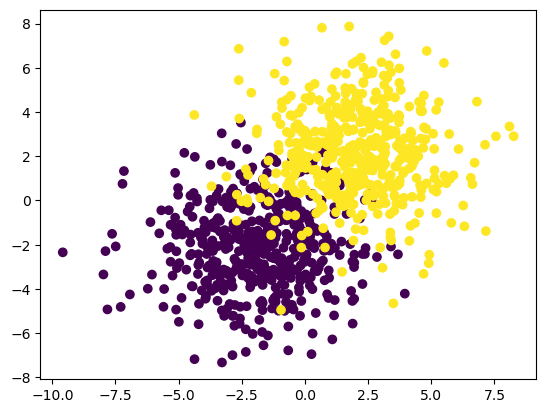

In [44]:
# 1.生成数据集
features, labels = gen_cls_data(bias=True)
# 可视化展示
plt.scatter(features[:, 0], features[:, 1], c=labels)
plt.show()

\# 2.模型选择：在前面线性模型的基础上增加Sigmoid激活函数即可，模型结构如下：

![sigmoid_nn](../assets/sigmoid_nn.png)

In [45]:
# 激活函数
def sigmoid(z):
    return 1 / (1 + torch.exp(-z))


# 逻辑回归模型
def logistic_reg(X, w):
    return sigmoid(X @ w)


# 准确率计算
def accuracy(sigma, y, prob=0.5):
    clses = (sigma >= prob).float()  # 将连续数值转化为类别
    bools = clses == y
    acc = bools.float().mean()
    return acc

In [46]:
# 3.定义损失函数
def cross_entropy(sigma, y):
    return -(y * sigma.log() + (1 - y) * (1 - sigma).log()).sum() / y.size(0)

In [47]:
# 4.定义优化器
def sgd(params, lr):
    params.data -= lr * params.grad
    params.grad.zero_()

In [48]:
# 5.训练模型
# 定义超参数
lr = 0.03
num_epochs = 5
batch_size = 32

# 随机初始化权重
w = torch.randn(3, requires_grad=True)

# 定义模型和损失函数
model = logistic_reg
criterion = cross_entropy

# 训练迭代
for epoch in range(num_epochs):
    for X, y in data_split_batches(batch_size, features, labels):
        sigma = model(X, w)
        loss = criterion(sigma, y.squeeze())
        loss.backward()
        sgd(w, lr)
    acc = accuracy(model(features, w), labels.squeeze())
    print(f'epoch {epoch} acc: {acc.item():.6f}')
    writer.add_scalar('acc_losgistic_reg_by_hand', acc, epoch)

epoch 0 acc: 0.857000
epoch 1 acc: 0.909000
epoch 2 acc: 0.916000
epoch 3 acc: 0.927000
epoch 4 acc: 0.932000


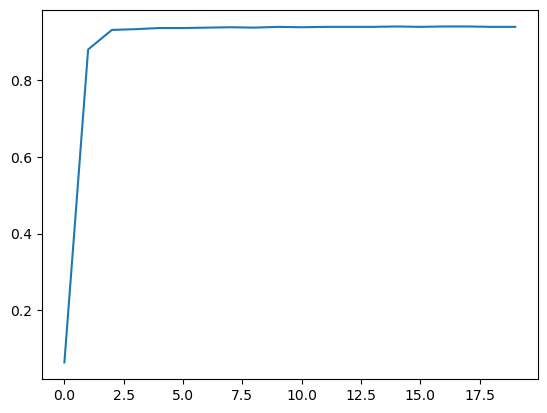

In [49]:
# 6.模型调试
# （1）增大epoch，查看准确率是否继续提升
num_epochs = 20

# 随机初始化权重
w = torch.randn(3, requires_grad=True)

# 训练迭代
train_acc = []
for rounds in range(num_epochs):
    for epoch in range(rounds):
        for X, y in data_split_batches(batch_size, features, labels):
            sigma = model(X, w)
            loss = criterion(sigma, y.squeeze())
            loss.backward()
            sgd(w, lr)
    acc = accuracy(model(features, w), labels.squeeze())
    train_acc.append(acc)
    writer.add_scalar('acc_losgistic_reg_by_hand', acc, epoch)

plt.plot(list(range(num_epochs)), train_acc)
plt.show()  # 增加迭代次数之后，损失函数逼近最小值点，准确率逐渐趋于平稳

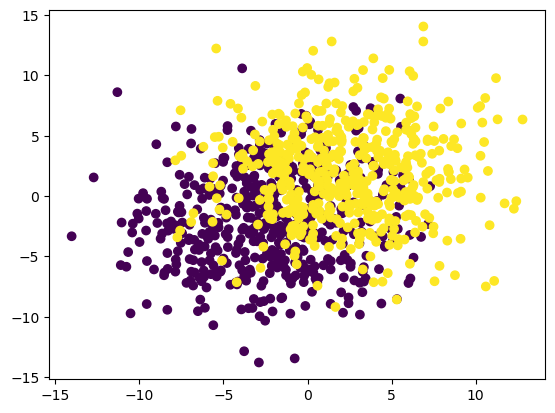

In [50]:
# （2）增加数据难度：增大数据的离散程度，查看对模型的效果影响
features, labels = gen_cls_data(bias=True, dispersions=(4, 4))
plt.scatter(features[:, 0], features[:, 1], c=labels)
plt.show()  # 类别之间的交错更多

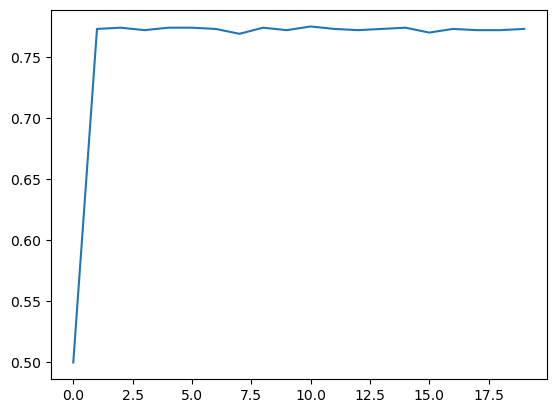

In [51]:
# 随机初始化权重
w = torch.zeros(3, requires_grad=True)

# 训练迭代
train_acc = []
for rounds in range(num_epochs):
    for epoch in range(rounds):
        for X, y in data_split_batches(batch_size, features, labels):
            sigma = model(X, w)
            loss = criterion(sigma, y.squeeze())
            loss.backward()
            sgd(w, lr)
    acc = accuracy(model(features, w), labels.squeeze())
    train_acc.append(acc)
    writer.add_scalar('acc_losgistic_reg_by_hand', acc, epoch)

plt.plot(list(range(num_epochs)), train_acc)
plt.show()  # 数据内部的离散程度增加时，准确率明显降低，模型的效果降低，此时需要增加模型复杂度

### 逻辑回归的快速实现

In [52]:
# 1.定义超参数
batch_size = 32
lr = 0.03
num_epochs = 5

In [53]:
# 2.构造数据
features, labels = gen_cls_data()
labels = labels.float()
data = TensorDataset(features, labels)
loader = DataLoader(data, batch_size=batch_size, shuffle=True)
loader

In [54]:
# 3.定义模型
class LR(nn.Module):
    def __init__(self, in_features=2, out_features=1):
        super().__init__()
        self.linear = nn.Linear(in_features, out_features)

    def forward(self, x):
        out = self.linear(x)
        return out


# 实例化模型
model = LR()
model

LR(
  (linear): Linear(in_features=2, out_features=1, bias=True)
)

In [55]:
# 4.定义损失函数
criterion = nn.BCEWithLogitsLoss()
criterion

BCEWithLogitsLoss()

In [56]:
# 5.定义优化器
optimizer = optim.SGD(model.parameters(), lr=lr)
optimizer

SGD (
Parameter Group 0
    dampening: 0
    lr: 0.03
    maximize: False
    momentum: 0
    nesterov: False
    weight_decay: 0
)

In [57]:
# 5.模型训练
# 定义训练函数
def fit(model, criterion, optimizer, data_loader, num_epochs):
    for epoch in range(num_epochs):
        for X, y in data_loader:
            z_hat = model(X)
            loss = criterion(z_hat, y)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        z_hat = model(features)
        loss = criterion(z_hat, labels)
        acc = accuracy(z_hat.sigmoid(), labels)
        print(f'epoch: {epoch} loss: {loss:.6f} acc: {acc:.6f}')


# 开始训练
fit(model, criterion, optimizer, loader, num_epochs)

epoch: 0 loss: 0.301138 acc: 0.882000
epoch: 1 loss: 0.221281 acc: 0.914000
epoch: 2 loss: 0.198044 acc: 0.923000
epoch: 3 loss: 0.185994 acc: 0.924000
epoch: 4 loss: 0.179635 acc: 0.925000


In [58]:
# 查看训练得到的权重
model.linear.weight.data, model.linear.bias.data

(tensor([[0.9050, 0.6745]]), tensor([-0.0629]))

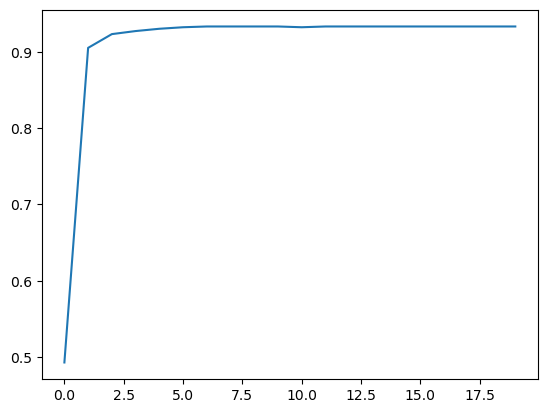

In [59]:
# 6.模型调试
# （1）增加迭代次数
num_epochs = 20

# 初始化模型和优化器
model = LR()
optimizer = optim.SGD(model.parameters(), lr=lr)

# 开始训练
train_acc = []
for rounds in range(num_epochs):
    for epoch in range(rounds):
        for X, y in loader:
            z_hat = model(X)
            loss = criterion(z_hat, y)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
    z_hat = model(features)
    acc = accuracy(z_hat.sigmoid(), labels)
    train_acc.append(acc)

plt.plot(list(range(num_epochs)), train_acc)
plt.show()  # 和之前手动实现一致，先准确率提升，并逐渐趋于稳定

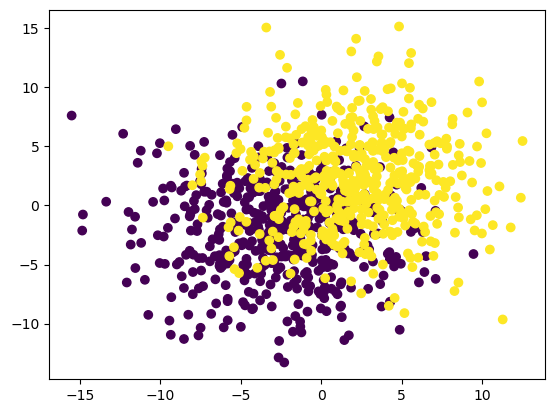

In [60]:
# （2）增加数据难度
# 构造数据
features, labels = gen_cls_data(dispersions=(4, 4))
labels = labels.float()
data = TensorDataset(features, labels)
loader = DataLoader(data, batch_size=batch_size, shuffle=True)

# 可视化
plt.scatter(features[:, 0], features[:, 1], c=labels)
plt.show()  # 数据的离散程度增大

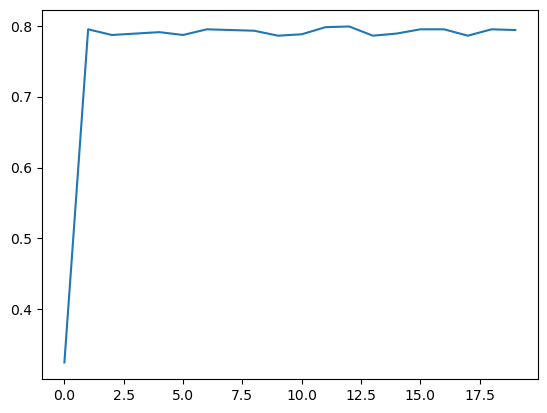

In [61]:
# 初始化模型和优化器
model = LR()
optimizer = optim.SGD(model.parameters(), lr=lr)

# 开始训练
train_acc = []
for rounds in range(num_epochs):
    for epoch in range(rounds):
        for X, y in loader:
            z_hat = model(X)
            loss = criterion(z_hat, y)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
    z_hat = model(features)
    acc = accuracy(z_hat.sigmoid(), labels)
    train_acc.append(acc)

plt.plot(list(range(num_epochs)), train_acc)
plt.show()  # 和之前手动实现一致，数据变复杂后，准确率明显降低

## 5.Softmax回归建模实验
### Softmax基础
Softmax是用于挑选最大值的一种方法，通过公式$\delta_k = \frac{e^{z_k}}{\sum^Ke^k}$对不同类的计算结果进行数值上的转化，这种转化可以将结果放缩到0-1之间，并且使用Softmax进行最大值的比较，相比max（Softmax是max的柔化版本），能有效避免损失函数求解时在0点不可导的问题，损失函数的函数特性，是后续选择优化算法的关键。

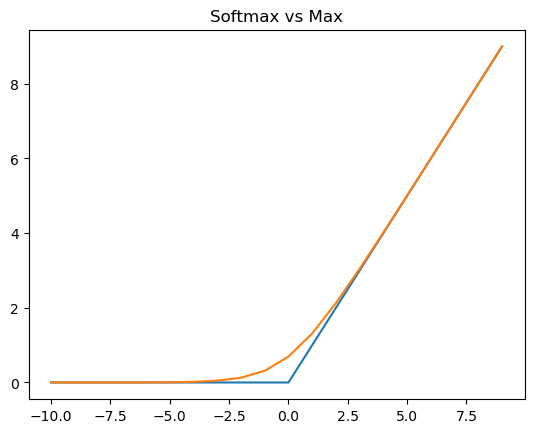

In [62]:
# max图像绘制
def max_(x, delta=0):
    x = np.array(x)
    x[x < delta] = 0
    return x


x = np.arange(-10, 10)
hinge_loss = max_(x)

plt.plot(x, hinge_loss)


# Softmax函数图像绘制
def softmax_(a, b):
    soft_x = 1 / (1 + np.exp(a - b))  # softmax操作
    ce = -np.log(soft_x)  # 负对数，即交叉熵损失
    return ce


a = np.arange(-10, 10)
b = 0
ce_loss = softmax_(a, b)

plt.plot(x, ce_loss)

plt.title('Softmax vs Max')
plt.show()

### Softmax回归的手动实现

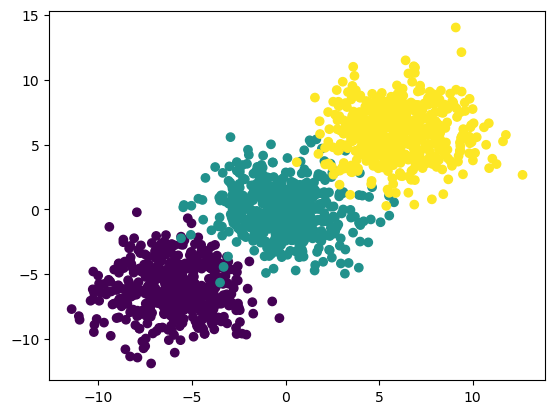

In [63]:
# 1.构造数据集
features, labels = gen_cls_data(num_classes=3, dispersions=(6, 2), bias=True)

# 可视化
plt.scatter(features[:, 0], features[:, 1], c=labels)
plt.show()

\# 2.选择模型
根据目标，建立一个只包含一层的神经网络进行建模。模型结构如下：

![handson_softmax_nn](../assets/handson_softmax_nn.png)

可以看到，输出层的每个神经元输出结果都代表某条样本在三个类别中Softmax后的取值，此时神经网络拥有两层，且是全连接。此时从特征到输出结果，就不再是简单的线性方程变换，而是矩阵相乘之后进行Softmax转化。实现如下。

In [64]:
def softmax(X, w):  # w: (输入数据特征数量, 输出神经元个数/类别数)
    exp_ = (X @ w).exp()
    sum_ = exp_.sum(-1).view(-1, 1)
    return exp_ / sum_

In [65]:
# 测试
w = torch.randint(10, size=(3, 3), dtype=torch.float)
X = features[:10]
softmax(X, w)

tensor([[1.0000e+00, 1.0386e-23, 8.5031e-27],
        [1.0000e+00, 0.0000e+00, 0.0000e+00],
        [1.0000e+00, 2.4916e-32, 2.3424e-36],
        [1.0000e+00, 3.0919e-30, 1.1392e-33],
        [1.0000e+00, 2.7265e-26, 2.5683e-29],
        [1.0000e+00, 3.6853e-30, 2.7146e-33],
        [1.0000e+00, 1.0277e-23, 2.9979e-26],
        [1.0000e+00, 1.1857e-31, 3.5586e-35],
        [1.0000e+00, 3.2165e-24, 2.7379e-27],
        [1.0000e+00, 2.0019e-28, 6.2912e-32]])

In [66]:
# 3.确定目标函数：交叉熵损失，每条数据的真实类别对应概率的累乘
def cross_entropy(soft_z, y):
    real_probs = torch.gather(soft_z, -1, y)  # 真实标签对应的概率
    return -real_probs.log().sum() / y.size(0)  # 为了防止相乘溢出带来的精度损失，将累乘转化为累加

In [67]:
# 测试
cross_entropy(softmax(X, w), labels[:10]), F.cross_entropy(X @ w, labels[:10].squeeze())  # 与官方提供的cross_entropy函数结果相同

(tensor(-0.), tensor(0.))

In [68]:
X.shape, w.shape

(torch.Size([10, 3]), torch.Size([3, 3]))

In [69]:
# 4.定义优化算法
def sgd(params, lr):
    params.data -= lr * params.grad
    params.grad.zero_()


# 计算准确率
def accuracy(soft_z, y):
    preds = torch.argmax(soft_z, -1)  # argmax函数获取最大概率的对应坐标
    bools = preds == y
    acc = bools.float().mean()
    return acc

In [70]:
# 5.模型训练

# 设置超参数
batch_size = 32
lr = 0.03
num_epochs = 5

# 初始化权重
w = torch.randn(3, 3, requires_grad=True)

# 定义模型和损失函数
model = softmax
criterion = cross_entropy

# 迭代训练
for epoch in range(num_epochs):
    for X, y in data_split_batches(batch_size, features, labels):
        sigma = model(X, w)
        loss = criterion(sigma, y)
        loss.backward()
        sgd(w, lr)
    sigma = model(features, w)
    acc = accuracy(sigma, labels.squeeze())
    print(f'epoch: {epoch} acc: {acc:.6f}')

epoch: 0 acc: 0.757333
epoch: 1 acc: 0.784000
epoch: 2 acc: 0.820000
epoch: 3 acc: 0.884000
epoch: 4 acc: 0.934000


In [71]:
# 查看模型结果
w

tensor([[-0.2146,  0.1722,  0.5003],
        [-0.5982, -0.2542,  0.2165],
        [-0.0981,  1.1192, -0.1557]], requires_grad=True)

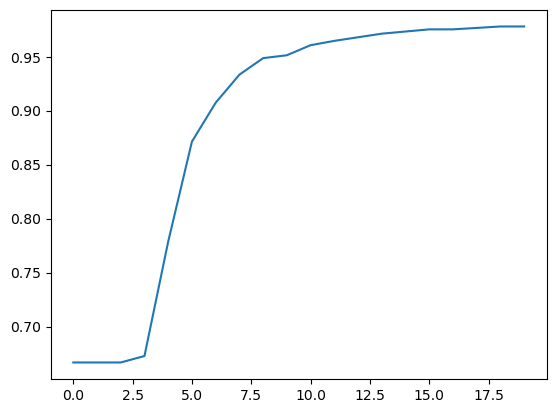

In [72]:
# 6.模型调试
# （1）增加迭代次数
num_epochs = 20

# 初始化权重
w = torch.randn(3, 3, requires_grad=True)

# 定义模型和损失函数
model = softmax
criterion = cross_entropy

# 迭代训练
train_acc = []
for epoch in range(num_epochs):
    for X, y in data_split_batches(batch_size, features, labels):
        sigma = model(X, w)
        loss = criterion(sigma, y)
        loss.backward()
        sgd(w, lr)
    sigma = model(features, w)
    acc = accuracy(sigma, labels.squeeze())
    train_acc.append(acc)

plt.plot(range(num_epochs), train_acc)
plt.show()  # 模型效果提升，并逐渐趋于稳定，模型收敛较快

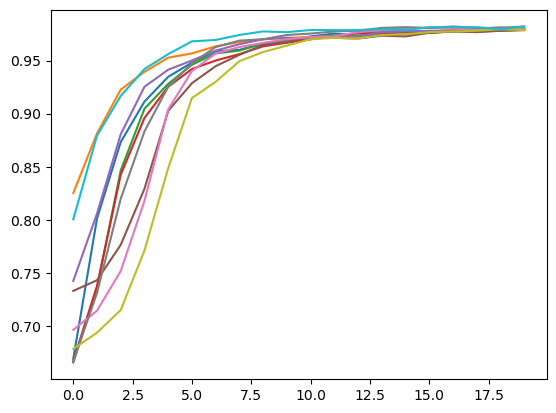

In [73]:
# （2）查看w不同的初始化下，模型的收敛
for _ in range(10):
    w = torch.randn(3, 3, requires_grad=True)
    train_acc = []
    for epoch in range(num_epochs):
        for X, y in data_split_batches(batch_size, features, labels):
            sigma = model(X, w)
            loss = criterion(sigma, y)
            loss.backward()
            sgd(w, lr)
        sigma = model(features, w)
        acc = accuracy(sigma, labels.squeeze())
        train_acc.append(acc)

    plt.plot(range(num_epochs), train_acc)
plt.show()  # w会影响前提模型的准确率，但是模型都收敛较快，能很快趋于稳定，数据对模型来说难度不大，都能轻松找到最小值，也证明了梯度下降算法本身的有效性

### Softmax回归的快速实现

In [74]:
# 1.定义超参数
lr = 0.03
num_epochs = 5
batch_size = 64

In [75]:
# 2.构造数据
features, labels = gen_cls_data(num_classes=3, dispersions=(6, 2))
labels.squeeze_()
data = TensorDataset(features, labels)
loader = DataLoader(data, batch_size=batch_size, shuffle=True)
features.shape, labels.shape

(torch.Size([1500, 2]), torch.Size([1500]))

In [76]:
# 3.定义模型
class SoftmaxRegression(nn.Module):
    def __init__(self, in_features=2, out_features=3):
        super().__init__()
        self.linear = nn.Linear(in_features, out_features)

    def forward(self, x):
        out = self.linear(x)
        return out


# 实例化模型
model = SoftmaxRegression()
model

SoftmaxRegression(
  (linear): Linear(in_features=2, out_features=3, bias=True)
)

In [77]:
# 4.定义损失函数
criterion = nn.CrossEntropyLoss()
criterion

CrossEntropyLoss()

In [78]:
# 5.定义优化器
optimizer = optim.SGD(model.parameters(), lr=lr)
optimizer

SGD (
Parameter Group 0
    dampening: 0
    lr: 0.03
    maximize: False
    momentum: 0
    nesterov: False
    weight_decay: 0
)

In [79]:
# 6.迭代训练
# 定义训练函数
def fit(model, criterion, optimizer, data_loader, num_epochs):
    for epoch in range(num_epochs):
        for X, y in data_loader:
            z_hat = model(X)
            loss = criterion(z_hat, y)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        z_hat = model(features)
        loss = criterion(z_hat, labels)
        acc = accuracy(F.softmax(z_hat, -1), labels)
        print(f'epoch: {epoch} loss: {loss:.6f} acc: {acc:.6f}')


# 开始训练
fit(model, criterion, optimizer, loader, num_epochs)

epoch: 0 loss: 0.666682 acc: 0.666000
epoch: 1 loss: 0.551736 acc: 0.698000
epoch: 2 loss: 0.470145 acc: 0.734667
epoch: 3 loss: 0.409520 acc: 0.779333
epoch: 4 loss: 0.364832 acc: 0.825333


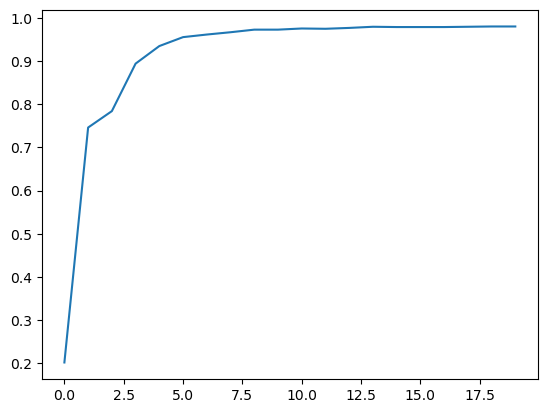

In [80]:
# 7.模型调试
# （1）增加迭代次数
num_epochs = 20

# 实例化模型和优化器
model = SoftmaxRegression()
optimizer = optim.SGD(model.parameters(), lr=lr)

# 迭代训练
train_acc = []
for rounds in range(num_epochs):
    for epoch in range(rounds):
        for X, y in loader:
            z_hat = model(X)
            loss = criterion(z_hat, y)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
    z_hat = model(features)
    acc = accuracy(F.softmax(z_hat, -1), labels)
    train_acc.append(acc)

plt.plot(range(num_epochs), train_acc)
plt.show()  # 很快能收敛

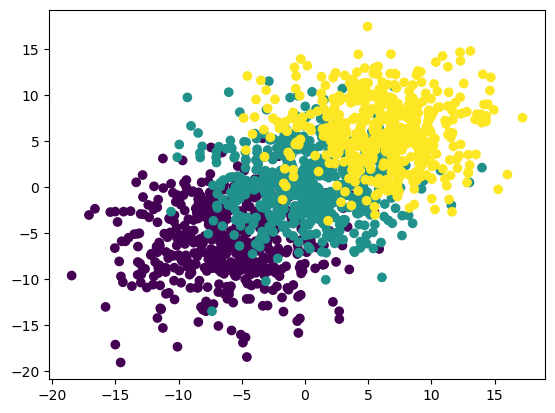

In [81]:
# （2）增大数据难度
features, labels = gen_cls_data(num_classes=3, dispersions=(6, 4))
labels.squeeze_()
data = TensorDataset(features, labels)
loader = DataLoader(data, batch_size=batch_size, shuffle=True)

# 可视化
plt.scatter(features[:, 0], features[:, 1], c=labels)
plt.show()  # 数据重叠较大

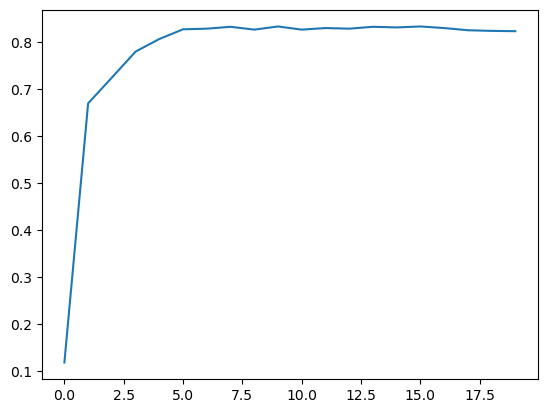

In [82]:
# 实例化模型和优化器
model = SoftmaxRegression()
optimizer = optim.SGD(model.parameters(), lr=lr)

# 迭代训练
train_acc = []
for rounds in range(num_epochs):
    for epoch in range(rounds):
        for X, y in loader:
            z_hat = model(X)
            loss = criterion(z_hat, y)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
    z_hat = model(features)
    acc = accuracy(F.softmax(z_hat, -1), labels)
    train_acc.append(acc)

plt.plot(range(num_epochs), train_acc)
plt.show()  # 收敛仍然很快，但是准确率明显降低，模型达到判别能力上限：模型已经到达（逼近）损失函数的最小值点，但模型的评估指标却无法继续提升

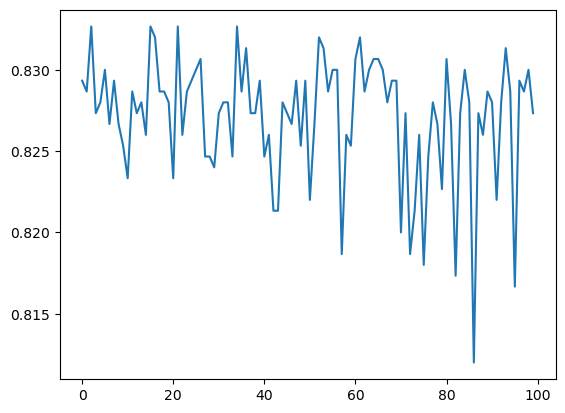

In [83]:
# 验证损失函数是逼近最小值点还是在局部最小值点附近
train_acc = []
for _ in range(100):
    model = SoftmaxRegression()
    optimizer = optim.SGD(model.parameters(), lr=lr)
    for epoch in range(num_epochs):
        for X, y in loader:
            z_hat = model(X)
            loss = criterion(z_hat, y)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
    z_hat = model(features)
    acc = accuracy(F.softmax(z_hat, -1), labels)
    train_acc.append(acc)

plt.plot(range(100), train_acc)
plt.show()  # 多次重新初始化模型，即初始化不同的w，最终的准确率都在一个稳定的区间，印证了模型效果降低是与迭代过程和损失函数无关的，需要调整模型结构来提升模型效果